# Introduction to physics informed neural networks (PINNs)

This Colab notebook builds a physics-informed neural network to approximate the solution to a PDE.
* PINNs use the PDE as a constraint/loss function to train a neural network.
* There may be additional constraints that come from boundary/initial conditions and data misfit.  


In this tutorial we will consider two examples:
* 1D Wave equation
* 1D Burger's equation


##### Example 1 --- 1D Wave equation
$$ \frac{\partial^2 u}{\partial x^2} = \frac{1}{C} \frac{\partial^2 u}{\partial t^2} \quad \forall x, t \in [0, 1] \times [0, 1]$$
$$ u(x,0) = \frac{1}{2} \sin(2\pi x) \text{ and } u(0, t)=u(1, t)=0 \text{ and } \frac{\partial u(x, 0)}{\partial t} \Big\rvert = 0$$


We will approximate the solution to the PDE using a neural network, i.e, $\hat{u}(x, t) = \mathcal{NN}(x, t)$\
Loss function $\mathcal{L} := \mathcal{L}_{\mathrm{PDE}} + \lambda_{\mathrm{BC}} \mathcal{L}_{\mathrm{BC}} +  \lambda_{\mathrm{IC}}\mathcal{L}_{\mathrm{IC}}$, where $  \lambda_{\mathrm{BC}} =  \lambda_{\mathrm{IC}} = 2.0 $

$$\mathcal{L}_{\mathrm{PDE}} = \frac{1}{N_{\mathrm{pde}}} \sum_{i=1}^{N_{\mathrm{pde}}} \Bigg\lvert  \frac{\partial^2 \hat{u}(x^{(i)}, t^{(i)})}{\partial x^2} - \frac{1}{C} \frac{\partial^2 \hat{u}(x^{(i)}, t^{(i)})}{\partial t^2} \Bigg\rvert^2$$ 

$$ \mathcal{L}_{\mathrm{BC}} = \frac{1}{2N_{\mathrm{bc}}} \sum_{i=1}^{N_{\mathrm{bc}}} \Big\lvert  \hat{u}(0, t^{(i)}) \Big\rvert^2 + \Big\lvert \hat{u}(1, t^{(i)}) \Big\rvert^2$$

$$ \mathcal{L}_{\mathrm{IC}} = \frac{1}{2N_{\mathrm{ic}}} \sum_{i=1}^{N_{\mathrm{ic}}} \Big\lvert  \hat{u}(x^{(i)}, 0) - \frac{1}{2}\sin(2\pi x^{(i)}) \Big\rvert^2 + \Big\lvert \frac{\partial u(x^{(i)}, 0)}{\partial t} \Big\rvert^2$$


#### Steps
1. Import necessary modules and packages, and manually fix the seed. 
2. Define a function to initialize a fully-connected neural network which will approximate the solution (from previous tutorial)
3. Define a function to compute the PINNs loss
4. Train the neural network
5. Plot the loss and the solution to the wave equation

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Neural network -- Creation and initialization

The following code cell:
* Creates a function which returns fully-connected neural network based on the user-specified width, depth and activation type.
* Initializes the neural network for training. 

In [3]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_dim=2, output_dim=1, width=5, depth=3, activation='relu'):
        super().__init__()
        self.input_dim = input_dim          # input dimension
        self.output_dim = output_dim        # output dimension
        self.width = width                  # width of hidden layers
        self.depth = depth                  # number of hidden layers + output layer
        if activation == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation == 'tanh':
            self.activation = torch.nn.Tanh()
        else:
            raise ValueError('activation must be one of "relu", "tanh", or "sin"')
        
        self.modules = []
        self.modules.append(torch.nn.Linear(input_dim, width))  # input layer
        self.modules.append(self.activation)                    # activation function
        for _ in range(depth-1):
            self.modules.append(torch.nn.Linear(width, width))  # hidden layers
            self.modules.append(self.activation)                # activation function
        
        self.modules.append(torch.nn.Linear(width, output_dim)) # output layer
        self.net = torch.nn.Sequential(*self.modules)           # combine all layers

    def forward(self, x):
        return self.net(x)

#### Loss functions

The following code cell:
* develops a function that computes the PINNs loss. 

In [4]:
def pinns_loss(net, t, x, t_bc, x_bc, t_ic, x_ic, u_ic_pred):
    '''Compute the loss function for the PINNs
    Args:
        net: torch.nn.Module, neural network
        t: torch.Tensor, time points for PDE loss
        x: torch.Tensor, space points for PDE loss
        t_bc: torch.Tensor, time points for boundary condition loss
        x_bc: torch.Tensor, space points for boundary condition loss
        t_ic: torch.Tensor, time points for initial condition loss
        x_ic: torch.Tensor, space points for initial condition loss
        u_ic_pred: torch.Tensor, predicted initial condition
    '''
    # Compute the solution
    u = net(torch.cat([t, x], 1))

    # Compute the gradients of u w.r.t. t and x
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    # Compute the second derivative of u w.r.t. x
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    # Compute the loss function
    l_pde = u_xx - u_tt # PDE loss
    l_bc = net(torch.cat([t_bc, x_bc], 1))  # BC loss
    u_ic = net(torch.cat([t_ic, x_ic], 1))  
    l_ic = u_ic - u_ic_pred                 # IC loss
    du_t_ic = torch.autograd.grad(u_ic, t_ic, torch.ones_like(u_ic), create_graph=True, retain_graph=True)[0]

    loss = torch.mean(l_pde**2) + 10*torch.mean(l_bc**2) + 10*torch.mean(l_ic**2) + 10*torch.mean(du_t_ic**2)   # total loss
    return loss


#### Creating the collocation, boundary and initial condition training points

The following code cell:
* samples collocation points from the training domain
* samples points on the boundary to impose boundary and initial conditions

In [5]:
n_pde = 2000    # number of collocation points
n_bc = 100       # number of boundary points
n_ic = 100       # number of initial condition points

# Generate collocation points
x_collocation = torch.rand(n_pde, 1, requires_grad=True)
t_collocation = torch.rand(n_pde, 1, requires_grad=True)

'''
We need to turn on the requires_grad attribute so that we can compute the gradients of the solution w.r.t. t and x.
'''

# Generate boundary points
x_ic = torch.rand(n_ic, 1, requires_grad=True)
t_ic = torch.zeros(x_ic.shape[0], 1, requires_grad=True)
u_ic_pred = 0.5*torch.sin(2*np.pi*x_ic)

# Generate initial condition points
t_bc = torch.rand(n_ic, 1, requires_grad=True)
x_bc = torch.ones(t_bc.shape[0], 1)
x_bc[:int(0.5*x_bc.shape[0])] = 0.0
x_bc.requires_grad = True

#### Neural network -- Training

The following code cell:
* specifies learning and model hyper-parameters for the neural network.
* trains the neural network.

In [6]:
model = NeuralNetwork(input_dim=2, output_dim=1, width=16, depth=3, activation='tanh')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_history = []   # history of loss function values
model.train()       # set the model to training mode
for i in range(10000):
    optimizer.zero_grad()           # clear the gradients
    loss = pinns_loss(model, t_collocation, x_collocation, t_bc, x_bc, t_ic, x_ic, u_ic_pred)   # compute the loss function
    loss.backward(retain_graph=True)    # backpropagate the gradients
    optimizer.step()                    # update the weights
    loss_history.append(loss.item())    # save the loss function value


Plot the loss history

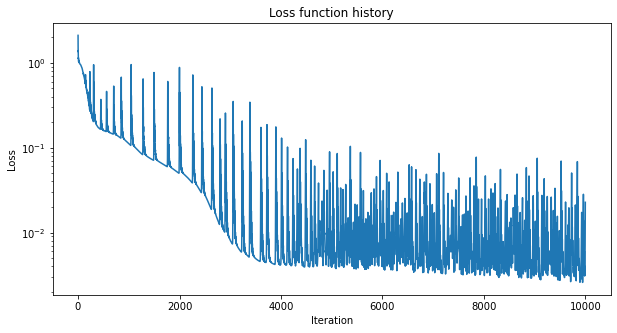

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss function history')
plt.show()

Plot the solution to the Wave equation

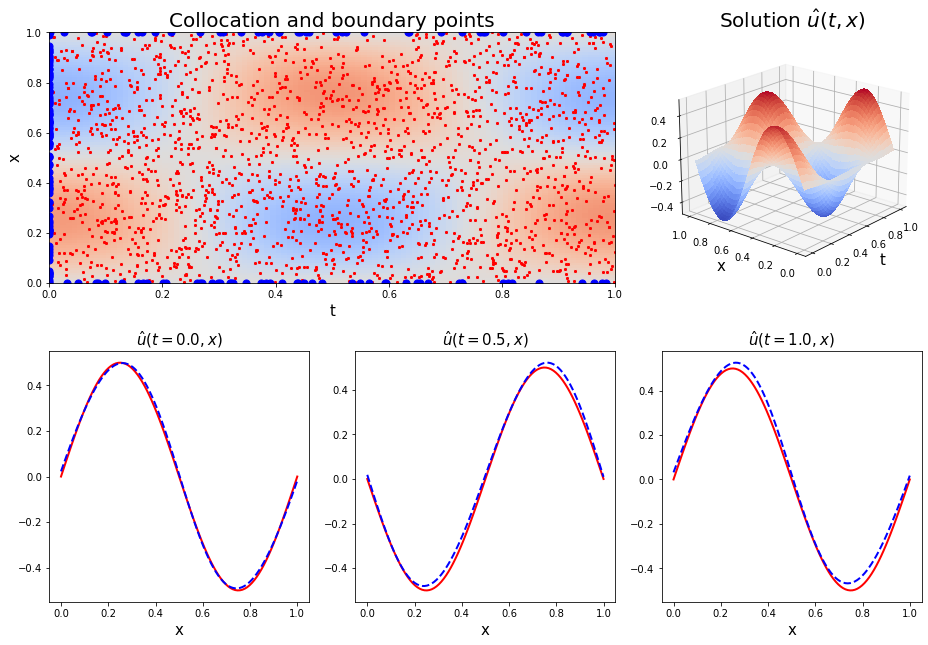

In [8]:
x = torch.linspace(0, 1, 100)
t = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x, t)

xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)
input = torch.cat((tcol, xcol), 1)
usol = model(input)
U = usol.reshape(x.numel(), t.numel())

xnp = x.numpy()
tnp = t.numpy()
Unp = U.detach().numpy()

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(13, 9))
gs = fig.add_gridspec(2, 3)

ax = fig.add_subplot(gs[0, :2])
h = ax.imshow(Unp,interpolation='nearest',cmap='coolwarm',extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], origin='lower', aspect='auto', vmax=1, vmin=-1)
ax.scatter(t_collocation.detach().numpy(), x_collocation.detach().numpy(), color='red', s=5, marker='x')
ax.scatter(t_ic.detach().numpy(), x_ic.detach().numpy(), color='blue', s=50, marker='o')
ax.scatter(t_bc.detach().numpy(), x_bc.detach().numpy(), color='blue', s=50, marker='o')
ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('x', fontsize=15)
ax.set_title(r'Collocation and boundary points', fontsize=20)


ax = fig.add_subplot(gs[0, 2], projection='3d')
ax.view_init(elev=20., azim=220)
ax.plot_surface(T.detach().numpy(), X.detach().numpy(), Unp, cmap='coolwarm',linewidth=0, antialiased=False)
ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('x', fontsize=15)
ax.set_title(r'Solution $\hat{u}(t,x)$', fontsize=20)


t_pnts = [0.00, 0.5, 1.0]
for i in range(3):
    t_col = torch.ones_like(xcol) * t_pnts[i]
    input = torch.cat((t_col, xcol), 1)
    usol = model(input)
    U = usol.reshape(x.numel(), t.numel())
    Unp = U.detach().numpy()
    ax = fig.add_subplot(gs[1, i])
    u_true = 0.5*np.sin(2*np.pi*xnp)*np.cos(2*np.pi*t_pnts[i])
    ax.plot(xnp, u_true, 'r-', linewidth=2)
    ax.plot(xnp, Unp[:,0], 'b--', linewidth=2)
    ax.set_xlabel('x', fontsize=15)
    ax.set_title(r'$\hat{u}(t='+str(t_pnts[i])+',x)$', fontsize=15)

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()